In [65]:
import os
import random
import json
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageColor
from utils.dataset import load_mask, load_bboxes, load_classIdxMap, load_stafflines
from utils.metropolis_hastings import metropolis_hastings, binomial_distribution, propose_state, probability_matrix

DATASET_PATH = os.path.join("..", "..", "datasets", "generated")
PNG_PATH = os.path.join(DATASET_PATH, "png")
BBOX_PATH = os.path.join(DATASET_PATH, "bbox")

OUT_PATH = os.path.join(DATASET_PATH, "unet")
OUT_TRAIN_PATH_X = os.path.join(OUT_PATH, "train", "x")
OUT_TRAIN_PATH_Y = os.path.join(OUT_PATH, "train", "y")
OUT_TEST_PATH_X = os.path.join(OUT_PATH, "test", "x")
OUT_TEST_PATH_Y = os.path.join(OUT_PATH, "test", "y")

with open(os.path.join(DATASET_PATH, "classlist.json")) as file:
    classlist = json.load(file)
    colormap = {c['color']: c['id'] for c in classlist}

In [ ]:
def getSystemParams(systems, idx, eps=0):
    
    sys = systems[idx]
    x0 = max(0, sys["x"] - eps)
    y0 = max(0, sys["y"] - eps)
    x1 = x0 + sys["width"] + 2 * eps
    y1 = y0 + sys["height"] + 2 * eps
    factor = 256 / (sys["height"] + 2 * eps)
    
    def map_box_coords(x, y, w, h):
        x = int((x - x0) * factor)
        y = int((y - y0) * factor)
        w = int(w * factor)
        h = int(h * factor)
        return x, y, w, h
    
    def map_img(img):
        crop = img[y0:y1, x0:x1].astype(np.uint8)
        res = cv2.resize(crop, (int((x1 - x0) * factor), 256))
        return res
        
    return map_box_coords, map_img

In [86]:
out_idx = 1

# make output directories
os.makedirs(OUT_TRAIN_PATH_X, exist_ok=True)
os.makedirs(OUT_TRAIN_PATH_Y, exist_ok=True)
os.makedirs(OUT_TEST_PATH_X, exist_ok=True)
os.makedirs(OUT_TEST_PATH_Y, exist_ok=True)

for s_idx in tqdm(range(1, 26)):
    sample_idx = f"{s_idx:03d}"

    # for each sample:
    imgs = [cv2.imread(os.path.join(PNG_PATH, sample_idx, f"out-{i}.png")) for i in range(51)]
    bboxes = load_bboxes(BBOX_PATH, sample_idx, img_shape=imgs[0].shape)
    
    y_mapped = np.zeros(imgs[1].shape[:2], dtype=np.uint8)
    y_tmp = cv2.cvtColor(imgs[1], cv2.COLOR_BGR2RGB)
    for color in colormap:
        y_mapped[np.all(y_tmp == ImageColor.getcolor(color, 'RGB'), axis=2)] = colormap[color]

    systems = {bbox["id"]: bbox for bbox in bboxes if bbox["type"]=="System"}
    unique_types = list(set([bbox["type"] for bbox in bboxes if bbox["type"] != "System"]))

    for idx, type in enumerate(unique_types):
        
        # get all bboxes of current type
        tbs = [bbox for bbox in bboxes if bbox["type"] == type]
        if len(tbs)==0:
            print("no box found for:", type)
            continue
        
        # pick random bbox
        rand_idx = random.randint(0, len(tbs) - 1)
        bbox = tbs[rand_idx]
        cx = bbox["cx"]
        cy = bbox["cy"]
        w = bbox["width"]
        h = bbox["height"]
        
        # map to system coordinates
        map_box_coords, map_img = getSystemParams(systems, int(bbox["systemId"]))
        cx, cy, w, h = map_box_coords(cx, cy, w, h)
        img_x = map_img(imgs[0])
        
        # get frame centered around bbox center
        x0 = cx - 128
        x1 = cx + 128
        if x0 < 0:
            x0 = 0
            x1 = 256
        if x1 > img_x.shape[1]:
            x1 = img_x.shape[1]
            x0 = x1 - 256
            
        # split into train and test data
        if s_idx < 20:
            out_path_x = OUT_TRAIN_PATH_X
            out_path_y = OUT_TRAIN_PATH_Y
        else:
            out_path_x = OUT_TEST_PATH_X
            out_path_y = OUT_TEST_PATH_Y
        if s_idx == 20:
            out_idx = 1
        
        # crop and save x
        img_x = img_x[:, x0:x1]
        cv2.imwrite(os.path.join(out_path_x, f"{out_idx:03d}.png"), img_x)
        
        # crop and save y rgb
        img_y = map_img(imgs[1])[:, x0:x1]
        cv2.imwrite(os.path.join(out_path_y, f"{out_idx:03d}_vis.png"), img_y)
        
        # crop and save y int
        img_y_mapped = map_img(y_mapped)[:, x0:x1]
        cv2.imwrite(os.path.join(out_path_y, f"{out_idx:03d}_int.png"), img_y_mapped)
        
        img_y_multi = np.zeros((256, 256, 48), dtype=bool)
        for i in range(3, 51):
            img_y_multi[..., i-3] = np.any(map_img(imgs[i])[:, x0:x1] > 0, axis=2)
        np.save(os.path.join(out_path_y, f"{out_idx:03d}.npy"), img_y_multi)
        
        out_idx += 1

100%|██████████| 25/25 [12:31<00:00, 30.04s/it]


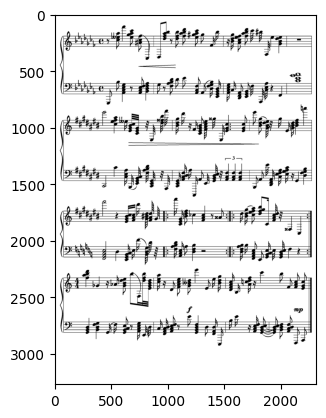

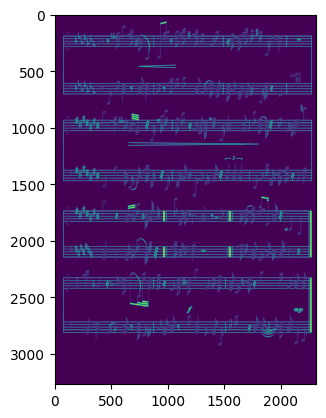

In [82]:
x_sample = cv2.imread(os.path.join(PNG_PATH, "001", "out-0.png"))
y_sample = cv2.imread(os.path.join(PNG_PATH, "001", "out-1.png"))
y_sample = cv2.cvtColor(y_sample, cv2.COLOR_BGR2RGB)
y_mapped = np.zeros(y_sample.shape[:2], dtype=np.uint8)
for color in colormap:
    y_mapped[np.all(y_sample == ImageColor.getcolor(color, 'RGB'), axis=2)] = colormap[color]
plt.imshow(x_sample)
plt.figure()


# np.all(y_sample == ImageColor.getcolor(color, 'RGB'), axis=2).shape#
plt.imshow(y_mapped)
